# Relax Inc. Challenge


Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday period, 
<br>**identify which factors predict future user adoption.**

<br>We suggest spending 1 to 2 hours on this, but you're welcome to spend more or less.
Please send us a brief writeup of your findings (the more concise, the better no
more than one page), along with any summary tables, graphs, code, or queries that can help
us understand your approach. Please note any factors you considered or investigation
you did, even if they did not pan out. Feel free to identify any further research or data
you think would be valuable.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
 

# Import data
 - **"takehome_users"** : A user table with data on 12,000 users who signed up for the product in the last two years.
 - **"takehome_user_engagement"** : A usage summary table that has a row for each day that a user logged into the product.

In [2]:
# User table with data on 12,000 users who signed up for the product in the last two years.
df_user = pd.read_csv('/Users/sandidge/Desktop/Python_Projects/Springboard_coursework/RelaxInc_takehome/takehome_users.csv', parse_dates=['creation_time', 'last_session_creation_time'], encoding = "cp1252")

# Usage summary table that has a row for each day that a user logged into the product.
df_engage = pd.read_csv('/Users/sandidge/Desktop/Python_Projects/Springboard_coursework/RelaxInc_takehome/takehome_user_engagement.csv', parse_dates=['time_stamp'])



In [3]:
# there is an issue with takehome_users, check encoding
with open("takehome_users.csv") as f:
    print(f.encoding)

UTF-8


# Exploratory Data Analysis

## Engagement data: takehome_user_engagement.csv

In [4]:
df_engage.info()
df_engage.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
df_engage.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


### Engagement over time

In [6]:
print(df_engage.time_stamp.min())
print(df_engage.time_stamp.max())

2012-05-31 08:20:06
2014-06-06 14:58:50


In [7]:
#convert timestamps to dates
df_engage['date'] = df_engage['time_stamp'].dt.date

# Table of users each day
daily_users = df_engage.groupby(['date'])['user_id'].count().to_frame().reset_index()


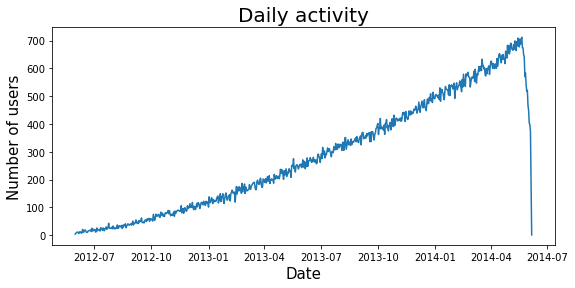

In [8]:
# Look at number of users each day
plt.rcParams["figure.figsize"] = (9,4)

plt.plot(daily_users['date'], daily_users['user_id'])
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Number of users', fontsize = 15)
plt.title('Daily activity', fontsize = 20)

plt.show()



### Visits by each user

In [9]:
# Count user visits
user_visits = df_engage.groupby(['user_id'])['visited'].sum().to_frame().reset_index().sort_values(by='visited', ascending = False)
user_visits


,user_id,visited
2652,3623,606
657,906,600
1315,1811,593
5548,7590,590
5877,8068,585
...,...,...
3440,4699,1
3439,4698,1
3438,4697,1
3437,4696,1


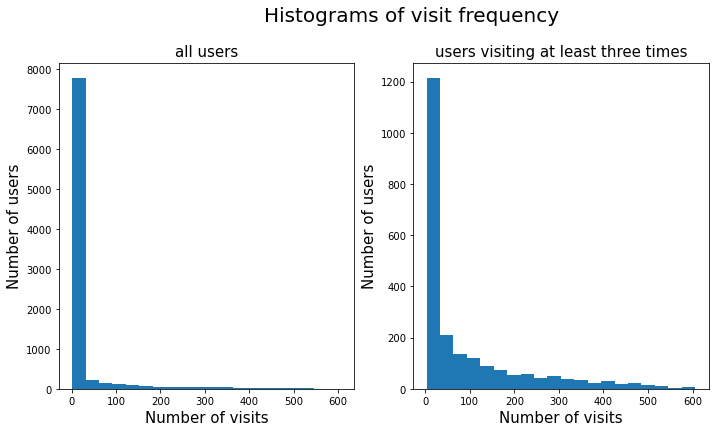

In [10]:
#set figure size
plt.figure(figsize=(18, 6))

# Histogram of number of visits by individual users
plt.subplot(131)
plt.hist(user_visits['visited'], bins = 20)
plt.xlabel('Number of visits', fontsize = 15)
plt.ylabel('Number of users', fontsize = 15)
plt.title('all users', fontsize = 15)

plt.subplot(132)
plt.hist((user_visits[user_visits['visited']>2])['visited'], bins = 20)
plt.xlabel('Number of visits', fontsize = 15)
plt.ylabel('Number of users', fontsize = 15)
plt.title('users visiting at least three times', fontsize = 15)

plt.suptitle('Histograms of visit frequency ', fontsize = 20, x=.4, y=1.01)
plt.show()


In [11]:
# Table of frequency of numbers of total visits
visit_freq = user_visits.groupby(['visited'])['visited'].count().to_frame()\
             .rename(columns={'visited': 'users'}).reset_index().rename(columns={'visited': 'visits'})
visit_freq.head(10)

,visits,users
0,1,6235
1,2,340
2,3,241
3,4,181
4,5,110
5,6,85
6,7,68
7,8,57
8,9,48
9,10,34


In [12]:
unique_list = df_engage['user_id'].unique()
unique_users = len(df_engage['user_id'].unique())
print('There are ', unique_users, ' unique users in the dataset')

#range_list = list(range(1,12000))
range_set = set(range(1,12000))
#range_list                  

# prints the missing and additional elements in list2 
missing = len((range_set.difference(set(unique_list))))
print("Number of missing ids (never logged on):", missing)


There are  8823  unique users in the dataset
Number of missing ids (never logged on): 3177


In [13]:
print("{:.1%}".format(missing/12000)+" percent of users never logged in")
print("{:.1%}".format(6235/12000)+" percent of users logged in once")


26.5% percent of users never logged in
52.0% percent of users logged in once


## Define adopted users

In [14]:
#set time stamp as index
df_engage = df_engage.set_index(df_engage.columns[0])

In [15]:
# sum the appearance of user ids in every 7 day rolling window
week_windows = df_engage.groupby('user_id').rolling('7D').count()

# get users who visited 3 or more times in at least one 7-day period
week_windows_adopted = week_windows[week_windows['visited']>=3].reset_index()

# get all unique adopted user ids
adopted_user_ids = week_windows_adopted['user_id'].unique()
print(len(adopted_user_ids), ' users were adopted')

#convert to a list
adopt_list = list(adopted_user_ids)

#convert list of int to str
adopt_list_str = list(map(str, adopt_list))

1602  users were adopted


In [16]:
print("{:.1%}".format((len(adopted_user_ids))/12000)+" percent of users were adopted")

13.4% percent of users were adopted


**Summary:**
<br>Engagement rose over the two-year sample period. Users logged on a minimum of zero times and a maximum of 606 times. There are 8,823 unique users who logged in at least once. Over a quarter (26.5%) of users never logged on and 52%, or 6235, users logged in only once. User adoption was calculated using a rolling 7-day window, resulting in 1,602 (13.4%) of users being classified as adopted.

## User information: takehome_users.csv', 

In [17]:
df_user.info()
df_user.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   object        
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 937.6+ KB


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240.0


In [18]:
df_user.describe()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,0.432742,0.356432,124.056723,3383.761968
min,1.00000,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.000000,1.000000,416.000000,11999.000000


In [19]:
mail = df_user['opted_in_to_mailing_list'].sum()
market = df_user['enabled_for_marketing_drip'].sum()
print("{:.1%}".format((mail)/12000)+" percent of users opted into the mailing list")
print("{:.1%}".format((market)/12000)+" percent of users enabled marketing outreach")

24.9% percent of users opted into the mailing list
14.9% percent of users enabled marketing outreach


creation_source
GUEST_INVITE          2163
ORG_INVITE            4254
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: object_id, dtype: int64


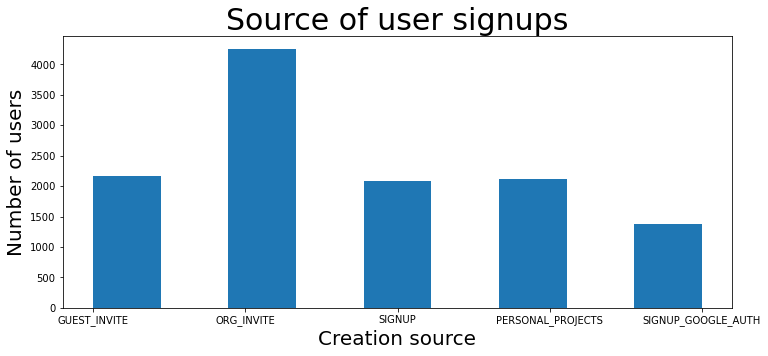

In [20]:
# get number of users for each creation source
print(df_user.groupby('creation_source')['object_id'].count())

#plt.rcParams["figure.figsize"] = (5,8)
plt.figure(figsize=(12, 5))

# Histogram of number of visits by individual users
plt.hist(df_user['creation_source'], bins=9)
plt.xlabel('Creation source', fontsize = 20)
plt.ylabel('Number of users', fontsize = 20)
plt.title('Source of user signups', fontsize = 30)

plt.show()

In [21]:
# Add email domain
df_user['domain'] = df_user['email'].apply(lambda x: x.split('@')[1])
print(df_user['domain'].value_counts().head(10))

# Create column of top six domains and 'other'
top_domains = ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com']
df_user['domains'] = df_user['domain'].apply(lambda x: x if x in top_domains else 'other')

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
rerwl.com            2
oqpze.com            2
qgjbc.com            2
dqwln.com            2
Name: domain, dtype: int64


**Summary:**
<br>24.9% of users opted into the mailing list and 14.9% enabled marketing. Organizational invite was the largets creation source. 

## Bring engagement data into user information table

In [22]:
#rename object_id as user_id to match df_engage
df_user = df_user.rename(columns={'object_id': 'user_id'})

In [23]:
# Add number of visits to user table
df_user = pd.merge(df_user, user_visits, on="user_id", how="left")


In [24]:
#create column of user ids in string format
df_user['id_str'] = df_user['user_id'].apply(str)

# add column with 1=adopted, 0=not adopted
df_user['adopted']= np.where(df_user['id_str'].isin(adopt_list_str), '1', '0')
df_user.sort_values(by=['visited'], ascending=False)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,domain,domains,visited,id_str,adopted
3622,3623,2012-06-25 14:34:33,Melo Vitória,VitoriaAlvesMelo@jourrapide.com,ORG_INVITE,1401201273,0,0,364,3623.0,jourrapide.com,jourrapide.com,606.0,3623,1
905,906,2012-06-17 22:49:52,Becker Jessika,JessikaBecker@gmail.com,SIGNUP_GOOGLE_AUTH,1401922192,0,0,358,NaN,gmail.com,gmail.com,600.0,906,1
1810,1811,2012-06-19 16:09:31,Carvalho Eduardo,EduardoCunhaCarvalho@gmail.com,SIGNUP_GOOGLE_AUTH,1400947771,1,1,33,NaN,gmail.com,gmail.com,593.0,1811,1
7589,7590,2012-06-08 00:51:13,Ferreira Rebeca,ffickuvv@qqgix.com,PERSONAL_PROJECTS,1401843073,0,0,225,NaN,qqgix.com,other,590.0,7590,1
8067,8068,2012-06-01 20:02:35,McCoy Donna,DonnaBMcCoy@hotmail.com,ORG_INVITE,1401393755,0,1,42,8068.0,hotmail.com,hotmail.com,585.0,8068,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11975,11976,2013-12-25 22:01:41,Kohl Leah,LeahKohl@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,248,NaN,hotmail.com,hotmail.com,NaN,11976,0
11977,11978,2014-04-23 16:28:06,Castro Pedro,PedroCunhaCastro@gustr.com,PERSONAL_PROJECTS,NaN,1,0,29,NaN,gustr.com,gustr.com,NaN,11978,0
11984,11985,2013-07-08 17:23:26,Jespersen Marcus,MarcusTJespersen@cuvox.de,PERSONAL_PROJECTS,NaN,0,0,74,NaN,cuvox.de,cuvox.de,NaN,11985,0
11992,11993,2013-03-28 23:24:21,Townsend Isabel,IsabelTownsend@cuvox.de,PERSONAL_PROJECTS,NaN,0,0,281,NaN,cuvox.de,cuvox.de,NaN,11993,0


In [25]:
#check adopted column is correct
print(len(df_user[df_user['adopted']=='1']))


1602


In [26]:
df_user.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,domain,domains,visited,id_str,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803.0,yahoo.com,yahoo.com,1.0,1,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316.0,gustr.com,gustr.com,14.0,2,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525.0,gustr.com,gustr.com,1.0,3,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151.0,yahoo.com,yahoo.com,1.0,4,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240.0,yahoo.com,yahoo.com,1.0,5,0


## Clean missing data

In [27]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   object        
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  domain                      12000 non-null  object        
 11  domains                     12000 non-null  object    

In [28]:
# Binary column for invited_by_user_id
df_user['invited'] = df_user['invited_by_user_id'].fillna(0)
df_user['invited']= df_user['invited'].apply(lambda x: 0 if x == 0 else 1)
print(len(df_user[df_user['invited']==1]), ' users were invited to join')


6417  users were invited to join


In [29]:
# NaN to zero, float to int
df_user['last_session_creation_time'] = df_user['last_session_creation_time'].fillna(0)
df_user['visited'] = df_user['visited'].fillna(0)
df_user['visited'] = df_user['visited'].astype(int)

df_user['adopted'] = df_user['adopted'].fillna(0)
df_user['adopted'] = df_user['adopted'].astype(int)



__________________________________________________
# Modeling user adoption with a Random Forest Classifier

<br>The Random Forest Classifier is used to predict a binary response and provides feature importances, which is what we want to explore.

### Features for model:
 - **creation_source**: how their account was created. This takes on one of 5 values.
    - PERSONAL_PROJECTS: invited to join another user's personal workspace
    - GUEST_INVITE: invited to an organization as a guest (limited permissions)
    - ORG_INVITE: invited to an organization (as a full member)
    - SIGNUP: signed up via the website
    - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
 - **creation_time**: when they created their account
 - **last_session_creation_time**: unix timestamp of last login
 - **opted_in_to_mailing_list**: whether they have opted into receiving marketing emails
 - **enabled_for_marketing_drip**: whether they are on the regular marketing email drip
 - **org_id**: the organization (group of users) they belong to
 - **invited_by_user_id**: which user invited them to join (if applicable).

In [30]:
#reassign for modeling
df_model = df_user

## Create dummies

In [31]:
# Get dummies for email domain
df_model = pd.get_dummies(df_model, columns=['domains'])
# Get dummies for Creation Source
df_model = pd.get_dummies(df_model, columns=['creation_source'])


In [32]:
df_model.head()

,user_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,domain,...,domains_gustr.com,domains_hotmail.com,domains_jourrapide.com,domains_other,domains_yahoo.com,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1398138810,1,0,11,10803.0,yahoo.com,...,0,0,0,0,1,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1396237504,0,0,1,316.0,gustr.com,...,1,0,0,0,0,0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1363734892,0,0,94,1525.0,gustr.com,...,1,0,0,0,0,0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1369210168,0,0,1,5151.0,yahoo.com,...,0,0,0,0,1,1,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1358849660,0,0,193,5240.0,yahoo.com,...,0,0,0,0,1,1,0,0,0,0


In [33]:
df_model.describe()

,user_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,adopted,invited,domains_cuvox.de,domains_gmail.com,domains_gustr.com,domains_hotmail.com,domains_jourrapide.com,domains_other,domains_yahoo.com,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
count,12000.00000,12000.000000,12000.000000,12000.000000,6417.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,0.249500,0.149333,141.884583,5962.957145,17.326417,0.133500,0.534750,0.100167,0.296833,0.098250,0.097083,0.104917,0.098833,0.203917,0.180250,0.354500,0.175917,0.173917,0.115417
std,3464.24595,0.432742,0.356432,124.056723,3383.761968,64.287839,0.340128,0.498812,0.300235,0.456881,0.297665,0.296084,0.306459,0.298451,0.402925,0.384412,0.478381,0.380765,0.379054,0.319537
min,1.00000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3000.75000,0.000000,0.000000,29.000000,3058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6000.50000,0.000000,0.000000,108.000000,5954.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9000.25000,0.000000,0.000000,238.250000,8817.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,12000.00000,1.000000,1.000000,416.000000,11999.000000,606.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
df_model.columns

Index(['user_id', 'creation_time', 'name', 'email',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'domain',
       'visited', 'id_str', 'adopted', 'invited', 'domains_cuvox.de',
       'domains_gmail.com', 'domains_gustr.com', 'domains_hotmail.com',
       'domains_jourrapide.com', 'domains_other', 'domains_yahoo.com',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

# Random Forest model: full model

In [35]:
# Filter out fields not used: ids, timestamps, names, emails
#['user_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 
#'id_str', 'org_id', 'invited_by_user_id'])

X_features = ['opted_in_to_mailing_list',
       'enabled_for_marketing_drip',
       'visited','invited', 'domains_cuvox.de',
       'domains_gmail.com', 'domains_gustr.com', 'domains_hotmail.com',
       'domains_jourrapide.com', 'domains_other', 'domains_yahoo.com',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH']

X = df_model[X_features]
y = df_model['adopted']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y, random_state = 42 )


In [36]:
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

### Find best parameters with GridSearch CV

In [37]:
# instantiate the classifier
rfc = RandomForestClassifier()

In [38]:
# create a parameter grid
param_grid = { 
    'n_estimators': [50, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [3,4,5,6],
    'criterion' :['gini', 'entropy']
}

In [39]:
# fit the random forest classifier
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 500]})

In [40]:
# get the best parameters
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'log2',
 'n_estimators': 50}

### Run the model using the best parameters 

In [41]:
# Fit a random forest classification model

rfc = RandomForestClassifier(random_state = 42,
                             n_estimators=50, 
                             max_depth=4,
                             max_features='log2',
                             criterion='entropy')
model_res = rfc.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.986
Random Forest: f1-score=0.986


### Confusion matrix

In [42]:
pl = confusion_matrix(y_test,y_pred)

Text(60.0, 0.5, 'Actual Label')

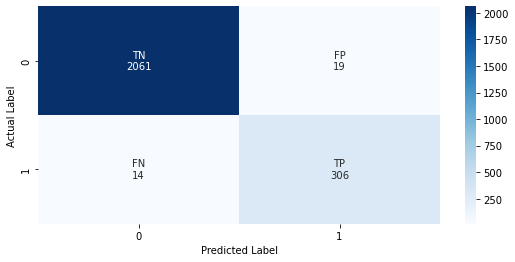

In [43]:
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = ['{0:0.0f}'.format(value) for value in
                pl.flatten()]
labels = [f'{name}\n{count}' for name, count in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(pl, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')

In [44]:
target_class = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_class))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2080
           1       0.94      0.96      0.95       320

    accuracy                           0.99      2400
   macro avg       0.97      0.97      0.97      2400
weighted avg       0.99      0.99      0.99      2400



16


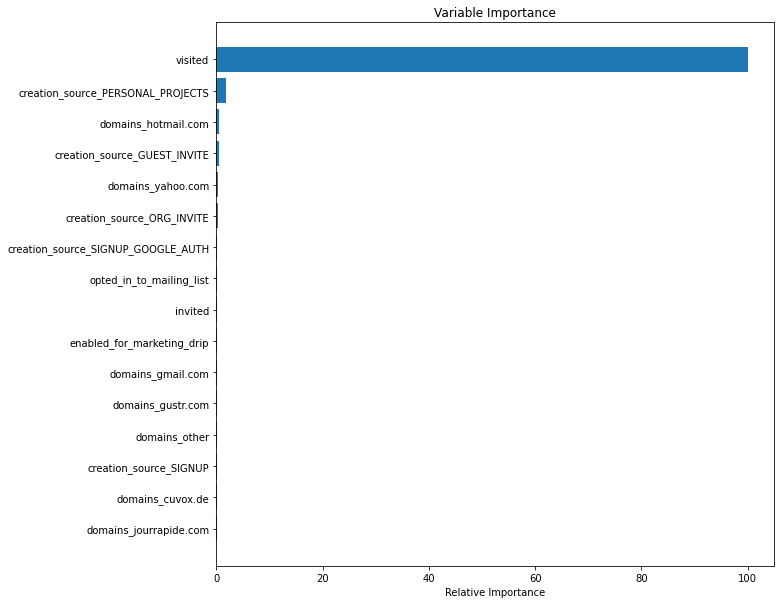

In [45]:
feature_importance = rfc.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Summary:
This model performs very well with an accuracy score of 96.8%. The model is mostly driven by the 'visited' feature describing the number of visits made by a user. This feature is directly related to the 'adopted' response as an adopted user has visited at least 3 times in a 7-day period. Naturally, users who visit more are more likely to adopt the software. It doesn't tell us much about who adopted users are.

_______________________
# Random Forest: remove 'visited' from model


In [46]:
# Filter out fields not used: ids, timestamps, names, emails
#['user_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 
#'id_str', 'org_id', 'invited_by_user_id', 'visited'])

X_features = ['opted_in_to_mailing_list',
       'enabled_for_marketing_drip',
       'invited', 'domains_cuvox.de',
       'domains_gmail.com', 'domains_gustr.com', 'domains_hotmail.com',
       'domains_jourrapide.com', 'domains_other', 'domains_yahoo.com',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH']

X = df_model[X_features]
y = df_model['adopted']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y, random_state = 42 )


In [47]:
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

### Find best parameters with GridSearch CV

In [48]:
# instantiate the classifier
rfc = RandomForestClassifier()

In [49]:
# create a parameter grid
param_grid = { 
    'n_estimators': [50, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [3,4,5,6],
    'criterion' :['gini', 'entropy']
}

In [50]:
# fit the random forest classifier
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 500]})

In [51]:
# get the best parameters
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'sqrt',
 'n_estimators': 50}

### Run the model using the best parameters 

In [ ]:
rfc = RandomForestClassifier(random_state = 42,
                             n_estimators=50, 
                             max_depth=3,
                             max_features='sqrt',
                             criterion='gini')
model_res = rfc.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

In [ ]:
pl = confusion_matrix(y_test,y_pred)

In [ ]:
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = ['{0:0.0f}'.format(value) for value in
                pl.flatten()]
labels = [f'{name}\n{count}' for name, count in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(pl, annot=labels, fmt='', cmap='Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')

In [ ]:
target_class = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_class))

In [ ]:
feature_importance = rfc.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Look at some important features as related to adopted user percentages

In [52]:
# look at software adoption among users with personal projects as creation source
personal_proj = df_model.groupby('creation_source_PERSONAL_PROJECTS')['user_id'].count().to_frame()
personal_proj2 = df_model.groupby('creation_source_PERSONAL_PROJECTS')['adopted'].sum().to_frame()
personal_proj['personal_proj_adopt'] = personal_proj2
personal_proj['percent_adopted'] = round((personal_proj['personal_proj_adopt']/personal_proj['user_id'])*100,2)

personal_proj

,user_id,personal_proj_adopt,percent_adopted
creation_source_PERSONAL_PROJECTS,,,
0,9889,1438,14.54
1,2111,164,7.77


In [53]:
# count number of accounts associated with each org_id
orgs = df_user.groupby('org_id')['user_id'].count().to_frame()
orgs2 = df_user.groupby('org_id')['adopted'].sum().to_frame()
orgs['org_adopt'] = orgs2
orgs['percent_adopted'] = round((orgs['org_adopt']/orgs['user_id'])*100,2)
#orgs.describe()
orgs


,user_id,org_adopt,percent_adopted
org_id,,,
0,319,11,3.45
1,233,14,6.01
2,201,15,7.46
3,168,14,8.33
4,159,16,10.06
...,...,...,...
412,17,0,0.00
413,16,3,18.75
414,20,2,10.00


In [54]:
# look at users who opted into inviteding list
invited = df_user.groupby('invited')['user_id'].count().to_frame()
invited2 = df_user.groupby('invited')['adopted'].sum().to_frame()
invited['invited_adopt'] = invited2
invited['percent_adopted'] = round((invited['invited_adopt']/invited['user_id'])*100,2)

invited

,user_id,invited_adopt,percent_adopted
invited,,,
0,5583,689,12.34
1,6417,913,14.23


In [55]:
# look at users who opted into mailing list
mail = df_user.groupby('opted_in_to_mailing_list')['user_id'].count().to_frame()
mail2 = df_user.groupby('opted_in_to_mailing_list')['adopted'].sum().to_frame()
mail['mail_adopt'] = mail2
mail['percent_adopted'] = round((mail['mail_adopt']/mail['user_id'])*100,2)

mail

,user_id,mail_adopt,percent_adopted
opted_in_to_mailing_list,,,
0,9006,1188,13.19
1,2994,414,13.83


In [56]:
# look at users who opted into marketing drip
market = df_user.groupby('enabled_for_marketing_drip')['user_id'].count().to_frame()
market2 = df_user.groupby('enabled_for_marketing_drip')['adopted'].sum().to_frame()
market['market_adopt'] = market2
market['percent_adopted'] = round((market['market_adopt']/market['user_id'])*100,2)

market

,user_id,market_adopt,percent_adopted
enabled_for_marketing_drip,,,
0,10208,1356,13.28
1,1792,246,13.73


## Summary:

Both models, with and without the number of user visits indicate similar patters. Using the software for a personal project is strongly, negatively related to adoption. Adoption among all users is a bit over 13 percent, but is only 7.77 percent for those with personal projects.
Being invited by another user, opting into the mailing list, and signing up for marketing outreach are positively related to user adoption and have adoption percentages higher than the average. 